In [ ]:
# Use the entire width of the screen if needed
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [43]:
import warnings
warnings.filterwarnings('ignore')

---

Here is a good resource explaining the details of choosing t and C for the Hamiltonian Simulation and the controlled rotation respectively.

https://quantumcomputing.com/strangeworks/harrow-hassidim-lloyd-hhl-algorithm

---

In [104]:
# Reset the kernel if needed

%reset -f

# import the relevant libraries etc.
# set up the environment

from qiskit import *
import numpy as np


%matplotlib inline



# Define the problem (the tridiagonal matrix that we are interested in solving)

a = 1
b = -1/3

# Problem size
n_w = 1
N_w = 2**n_w

In [105]:
# make the tridiagonal matrix in classical form
classical_matrix = np.zeros((N_w,N_w))

for _i in range(N_w):
    for _j in range(N_w):
        if _i==_j:
            classical_matrix[_i,_j]=a
        if abs(_i-_j)==1:
            classical_matrix[_i,_j]=b

print(classical_matrix)

[[ 1.         -0.33333333]
 [-0.33333333  1.        ]]


In [106]:
eigenvalues = np.linalg.eigvals(classical_matrix)

print('maximum: {}\nminimum: {}\nkappa: {}'.format(np.max(eigenvalues),np.min(eigenvalues),np.max(eigenvalues)/np.min(eigenvalues)))

maximum: 1.3333333333333333
minimum: 0.6666666666666667
kappa: 1.9999999999999998


In [107]:
# Define the eigenvalue register
n_l = 2

# Define the Trotterization
m = 10
# The order of the Trotter formula that we are using (shoot for the moon)

# Define the time; this depends on the spectrum and size of the clock register
t = np.pi/(max(abs(eigenvalues)))/(2**n_l-1)
# t = 1

# Define the registers for the problem
work_register = QuantumRegister(n_w,name='work')
clock_register = QuantumRegister(n_l,name='clock')
ancilla = AncillaRegister(1,name='controlled_rotation')



In [108]:
# Define the initial state of the system
# Implement this later after the unitary of the system is shown to be working fine


# Perhaps it is a good idea to pass the eigenvectors as the initial state and see if we recover the eigenvectors
# at the output

In [109]:
# Make a functions that return the different pieces of the hamiltonian (exponentiated) with the required amount
# of Hamiltonian simulation (requested t)

In [110]:
def H1(a,b,t,work_register,n_w):
    H1_circuit = QuantumCircuit(work_register,name='H1')
    H1_circuit.x(n_w-1)
    H1_circuit.p(a*t,n_w-1)
    H1_circuit.x(n_w-1)
    H1_circuit.p(a*t,n_w-1)
    H1_circuit.draw(output='mpl')
    return H1_circuit


def H2(a,b,t,work_register,n_w):
    H2_circuit = QuantumCircuit(work_register,name='H2')
    H2_circuit.rx(-2*b*t,n_w-1)
    H2_circuit.draw(output='mpl')
    return H2_circuit


def H3(a,b,t,work_register,n_w):
    H3_circuit = QuantumCircuit(work_register,name='H3')
    
    # H3 is made up of a bunch of C circuits
    C_circuits = []
    
    # We need to make a multi-controlled RX gate for each C
    from qiskit.circuit.library.standard_gates import RXGate
    
    for _C in range(1,n_w):
        _C_circuit = QuantumCircuit(work_register[-1-_C:],name='C{}'.format(_C))
        _C_circuit.cnot(1,0,ctrl_state=1)
        for _target in range(2,_C+1):
            _C_circuit.cnot(1,_target,ctrl_state=0)
        # Create the multi controlled Rx gate
        #if (_C-2)>=1:
        #    _rx_gate = RXGate(-2*b*dt).control(_C-2)
        #    _C_circuit.append(_rx_gate,[])
        _rx_gate = RXGate(-2*b*t).control(_C)
        _controls_targets = [_x for _x in range(_C+1) if _x != 1]
        _controls_targets.append(1)
        _C_circuit.append(_rx_gate,_controls_targets)
    

        for _target in reversed(range(2,_C+1)):
            _C_circuit.cnot(1,_target,ctrl_state=0)
        _C_circuit.cnot(1,0,ctrl_state=1)
        C_circuits.append(_C_circuit)
        
    # Append the C circuits to the overall H3 circuit
    #H3_circuit.barrier()
    for _C in C_circuits:
        H3_circuit = H3_circuit + _C
        #H3_circuit.barrier()
        
    return H3_circuit



In [111]:
# _H1 = H1(a,b,1,work_register,n_w)
# _H1.draw(output='mpl')

# _H2 = H2(a,b,1,work_register,n_w)
# _H2.draw(output='mpl')

# _H3 = H3(a,b,1,work_register,n_w)
# _H3.draw(output='mpl')

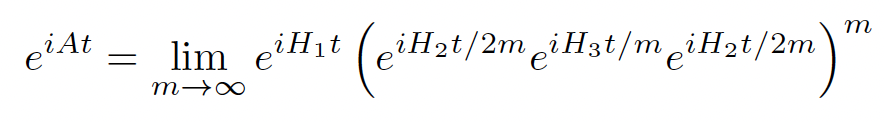
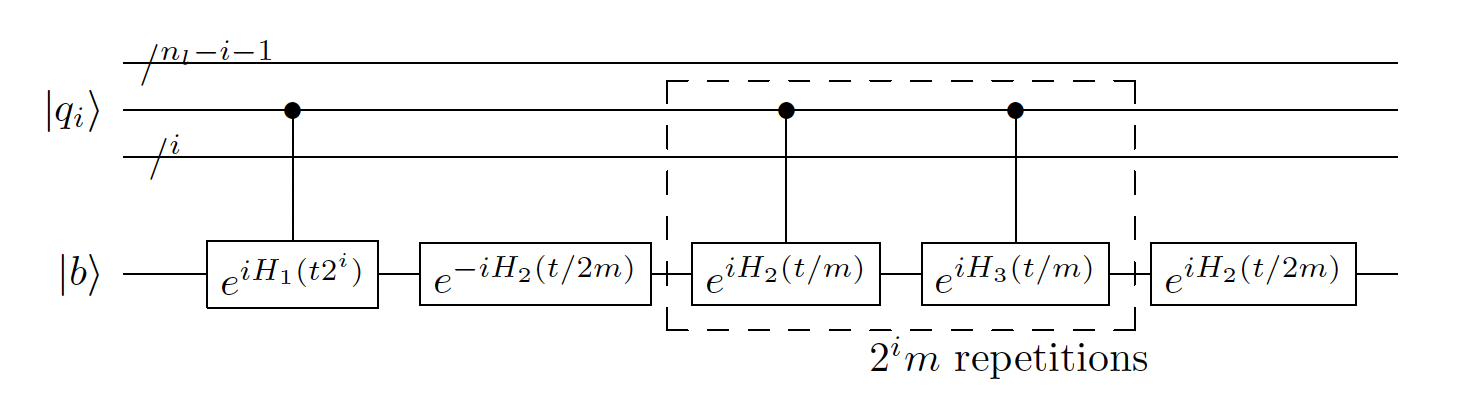

In [112]:
# Now we want to combine all the pieces together to make function that will return powers of U
# Basically we are going to repeat the circuit to apply the powers (H1 commutes so no need for that part)

# Note: i here is the power of 2 we are raising U to
def U_pow(a,b,t,work_register,n_w,m,i,return_circuit=False):
    U_pow_circuit = QuantumCircuit(work_register,name='U^{}'.format(2**i))
    U_pow_circuit = U_pow_circuit+H1(a,b,t*2**i,work_register,n_w)
    for _i in range((2**i)*m):
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H2(a,b,t/2/m,work_register,n_w)
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H3(a,b,t/m  ,work_register,n_w)
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H2(a,b,t/2/m,work_register,n_w)
        #U_pow_circuit.barrier()
    if not return_circuit:
        return U_pow_circuit.to_gate(label='U^{}'.format(int(np.sign(t))*2**i))
    else:
        return U_pow_circuit
        

In [113]:
# Now we can start working with the clock registers and start applying controlled versions of this circuit
# to make the QPE gate

# Qiskit uses the little endian convention
# This means that the most significant bit is the lowest qubit
# and the least significant bit is the highest qubit

QPE_circuit = QuantumCircuit(clock_register,work_register,name='QPE')

QPE_circuit.h(clock_register)
    
for _i in range(n_l):
    # Get the appropriate gate for the power
    U_i = U_pow(a,b,t,work_register,n_w,m,_i)
    c_U_i = U_i.control(1)
    QPE_circuit.append(c_U_i,[clock_register[n_l-1-_i]] + [_x for _x in work_register])
    
from qiskit.circuit.library import QFT
QPE_circuit = QPE_circuit.compose(QFT(num_qubits=n_l, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=False, name='IQFT'),clock_register)
#QPE_circuit = QPE_circuit.compose(_myqft,qubits=clock_register)

# QPE_circuit.draw(output='mpl')

QPE = QPE_circuit.to_gate(label='QPE')

In [114]:
# Define the HHL circuit
# This will have the ancilla, clock, and work registers along with a classical register which will be used to
# measure the ancilla qubit until success

HHL_circuit = QuantumCircuit(ancilla,clock_register,work_register,name='HHL')

HHL_circuit = HHL_circuit+QPE_circuit

HHL_circuit.draw()

controlled_rotation: ────────────────────────────
                     ┌───┐              ┌───────┐
            clock_0: ┤ H ├──────────■───┤0      ├
                     ├───┤          │   │  IQFT │
            clock_1: ┤ H ├───■──────┼───┤1      ├
                     └───┘┌──┴──┐┌──┴──┐└───────┘
               work: ─────┤ U^1 ├┤ U^2 ├─────────
                          └─────┘└─────┘

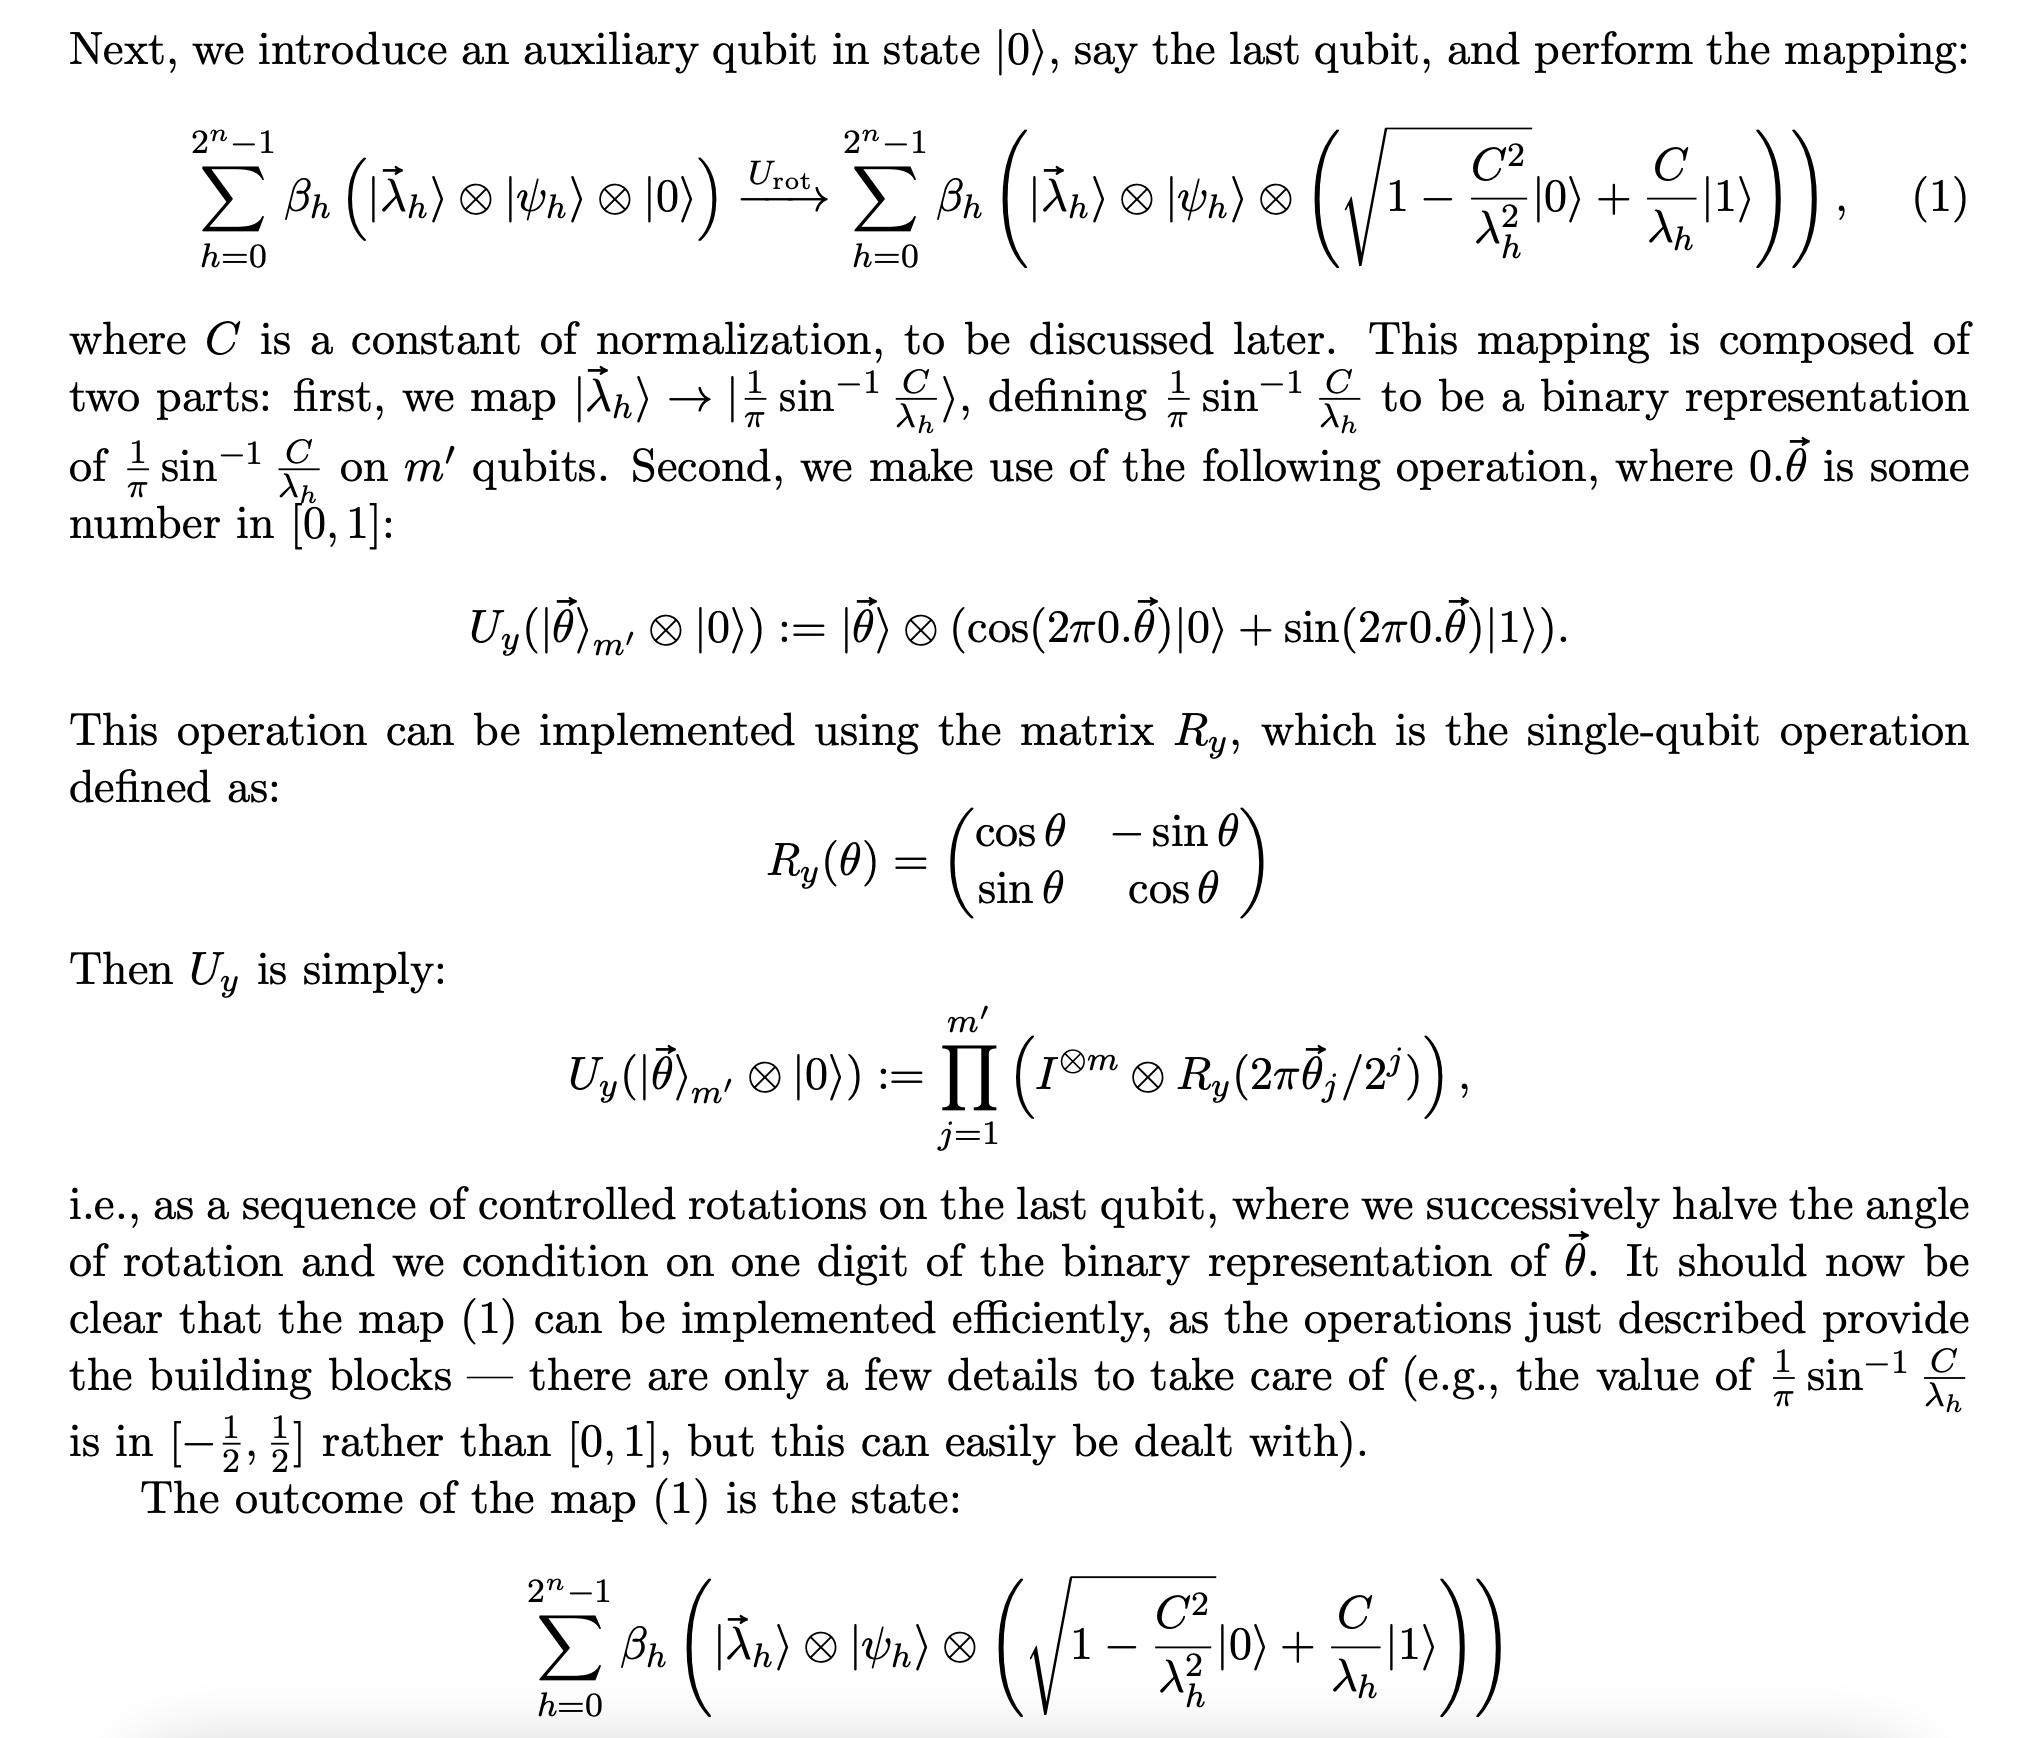

In [115]:
CROT_circuit = QuantumCircuit(ancilla,clock_register,name='Controlled Rotation')

for _i in reversed(range(n_l)):
    CROT_circuit.cry(np.pi*2/(2**(_i+1)), clock_register[_i], ancilla, label='{}'.format(_i))

# CROT_circuit.draw()

CROT = CROT_circuit.to_gate(label='CROT')
HHL_circuit = HHL_circuit + CROT_circuit
# HHL_circuit.draw()

This completes the controlled rotation portion, now we simply need to uncompute the QFT and QPE portions

In [116]:
iQPE_circuit = QuantumCircuit(clock_register,work_register,name='iQPE')

iQPE_circuit = iQPE_circuit.compose(QFT(num_qubits=n_l, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='QFT'),clock_register)



    
for _i in reversed(range(n_l)):
    # Get the appropriate gate for the power
    U_i = U_pow(a,b,-t,work_register,n_w,m,_i)
    c_U_i = U_i.control(1)
    iQPE_circuit.append(c_U_i,[clock_register[n_l-1-_i]] + [_x for _x in work_register])
iQPE_circuit.barrier()    
iQPE_circuit.h(clock_register)



# iQPE_circuit.draw()

In [117]:
HHL_circuit = HHL_circuit+iQPE_circuit
# HHL_circuit.draw()
# HHL_circuit.draw(output='mpl')

In [118]:
# Now we want to add a classical register to
# 1) Measure the ancilla
# 2) Measure the work register

# Create the classical register
# We want to combine the ancilla qubit and the work qubits
classical_register = ClassicalRegister(1 + n_w,name='results')

Full_circuit = QuantumCircuit(ancilla,clock_register,work_register,classical_register,name='HHL')

# We want to initialize the work qubits into our basis vector of choice
# This needs to be done in a better way to:
basis_vector = 0
# The endianness of the binary string is consistent with the endianness of Hamiltonian simulation
# Full_circuit.initialize('{0:b}'.format(basis_vector).zfill(n_w)[-n_w:],work_register)
#Full_circuit.initialize(basis_vector,work_register)
Full_circuit.barrier()


Full_circuit = Full_circuit + HHL_circuit
# Full_circuit.draw(output = 'mpl')

In [119]:
Full_circuit.barrier()
Full_circuit.measure(ancilla,classical_register[0])
Full_circuit.measure(work_register,classical_register[1:])

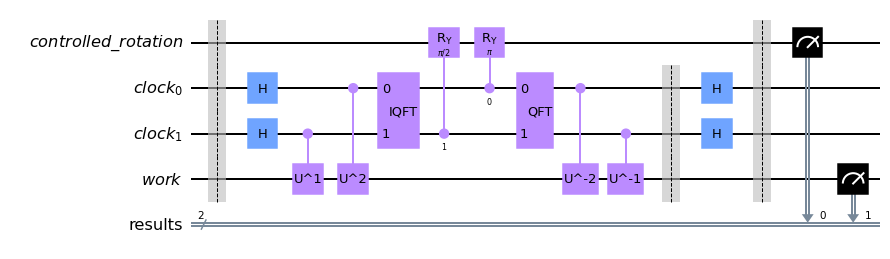

In [120]:
Full_circuit.draw(output='mpl')

In [121]:
# This circuit SHOULD work; when the ancilla is 1 we should be getting the result in the
# corresponding bits in the classical register

simulator = Aer.aer.get_backend('aer_simulator_statevector')
output = execute(Full_circuit,backend=simulator,shots=100000)

In [122]:
result = output.result().get_counts(Full_circuit)

In [123]:
print(result)

{'10': 2732, '11': 4752, '00': 61987, '01': 30529}


In [124]:
# We want to convert this result into the corresponding vector
# Note that we will need to be consistent with endianness of the result
# And then we want to compare it with the (norm-scaled) solution of the linear system

In [125]:
solution_counts = {}
# Check the ancilla for success and extract the count if there is one and store it with the resulting basis state
# Also reverse the order of the corresponding basis state to get back to Big Endian format
for _i in result.keys():
    _ancilla = _i[0]
    if _ancilla == '1':
        # Reverse and store the basis state with the count
        solution_counts[_i[1:][::-1]] = result[_i]
print(solution_counts)

{'0': 2732, '1': 4752}


In [126]:
# Now build the vector that corresponds to the solution vector with squared and normalized entries
quantum_solution = np.zeros((N_w,1))
for _basis in solution_counts.keys():
    quantum_solution[int(_basis,2)] = solution_counts[_basis]
quantum_solution = quantum_solution/np.linalg.norm(quantum_solution,2)
print(quantum_solution)

[[0.49841628]
 [0.86693784]]


In [127]:
classical_solution = np.linalg.solve(classical_matrix,np.eye(N_w,1,0))
classical_solution = np.power(classical_solution,2)
classical_solution = classical_solution/np.linalg.norm(classical_solution)
print(classical_solution)

[[0.99388373]
 [0.11043153]]


In [92]:
# Now we want to start testing out the Hamiltonian Simulation portion, whether we are getting the correct
# exponentiation of the matrix that we expect
m = 10
power = 3
U_exp = U_pow(a,b,t,work_register,n_w,m,power,return_circuit=True)



simulator = Aer.aer.get_backend("unitary_simulator")
unitary = execute(U_exp.reverse_bits(),simulator).result().get_unitary()
trotter_solution = unitary.data

from scipy.linalg import expm
i = 0+1j

exact_solution = np.linalg.matrix_power(expm(classical_matrix*t*i),2**power)

error = np.linalg.norm(trotter_solution-exact_solution,2)
print(error)

# If the error is going down for increasing Trotter steps (increasing m)
# then the Hamiltonian simulation is working fine

2.0524738895986516e-07


In [93]:
# Now we want to start testing out the Hamiltonian Simulation portion, whether we are getting the correct
# exponentiation of the matrix that we expect
from scipy.linalg import expm
i = 0+1j

#m = 10
power = 3

for m in [1,10,100]:
    U_exp = U_pow(a,b,t,work_register,n_w,m,power,return_circuit=True)

    simulator = Aer.aer.get_backend("unitary_simulator")
    unitary = execute(U_exp.reverse_bits(),simulator).result().get_unitary()
    trotter_solution = unitary.data

    exact_solution = np.linalg.matrix_power(expm(classical_matrix*t*i),2**power)

    error = np.linalg.norm(trotter_solution-exact_solution,2)
    print(error)

# If the error is going down for increasing Trotter steps (increasing m)
# then the Hamiltonian simulation is working fine

2.0526336837022917e-05
2.0524738895986516e-07
2.052670607079492e-09
